
Classification Report for Category:

              precision    recall  f1-score   support

   Appetizer       1.00      1.00      1.00         3
    Beverage       1.00      1.00      1.00         2
   Breakfast       1.00      1.00      1.00         3
     Dessert       1.00      1.00      1.00         6
 Main Course       1.00      1.00      1.00         7
       Salad       1.00      1.00      1.00         5
   Side Dish       1.00      1.00      1.00         5
       Snack       1.00      1.00      1.00         4
        Soup       1.00      1.00      1.00         1

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



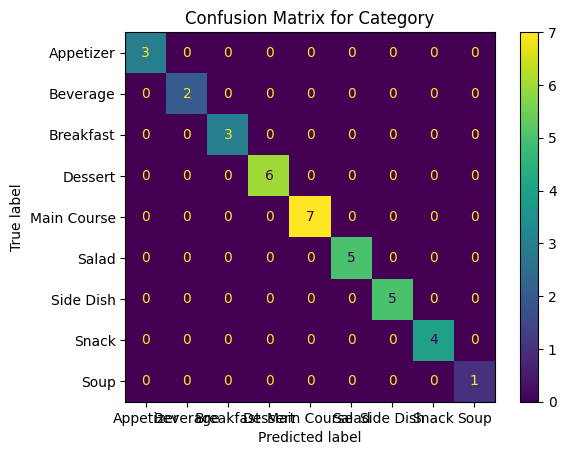


Classification Report for Cuisine:

               precision    recall  f1-score   support

     American       0.83      1.00      0.91         5
      Chinese       1.00      1.00      1.00         3
       French       1.00      0.80      0.89         5
        Greek       1.00      1.00      1.00         5
       Indian       1.00      1.00      1.00         3
      Italian       1.00      1.00      1.00         3
Mediterranean       1.00      1.00      1.00         3
      Mexican       1.00      1.00      1.00         7
         Thai       1.00      1.00      1.00         2

     accuracy                           0.97        36
    macro avg       0.98      0.98      0.98        36
 weighted avg       0.98      0.97      0.97        36



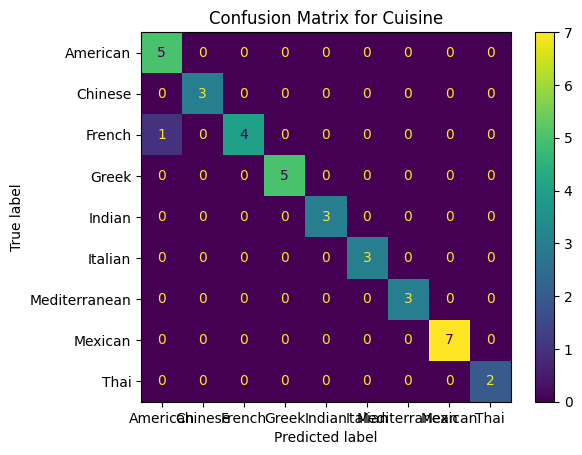


--- Found 14 matching recipes with similar ingredients ---

Recipe #1
Category: Appetizer
Cuisine: Italian
Matched Ingredients: tomato
All Ingredients:  tomato, basil, mozzarella, olive oil
--------------------------------------------------
Recipe #2
Category: Main Course
Cuisine: Italian
Matched Ingredients: tomato sauce
All Ingredients:  pasta, cheese, tomato sauce, oregano
--------------------------------------------------
Recipe #3
Category: Side Dish
Cuisine: Italian
Matched Ingredients: tomatoes
All Ingredients:  zucchini, tomatoes, oregano, olive oil
--------------------------------------------------
Recipe #4
Category: Salad
Cuisine: American
Matched Ingredients: tomato
All Ingredients:  tuna, lettuce, mayonnaise, tomato
--------------------------------------------------
Recipe #5
Category: Side Dish
Cuisine: Mediterranean
Matched Ingredients: tomatoes
All Ingredients:  eggplants, tomatoes, basil, olive oil
--------------------------------------------------
Recipe #6
Category:

[{'Category': 'Appetizer',
  'Cuisine': 'Italian',
  'Matched Ingredients': ['tomato'],
  'All Ingredients': ['tomato', 'basil', 'mozzarella', 'olive oil']},
 {'Category': 'Main Course',
  'Cuisine': 'Italian',
  'Matched Ingredients': ['tomato sauce'],
  'All Ingredients': ['pasta', 'cheese', 'tomato sauce', 'oregano']},
 {'Category': 'Side Dish',
  'Cuisine': 'Italian',
  'Matched Ingredients': ['tomatoes'],
  'All Ingredients': ['zucchini', 'tomatoes', 'oregano', 'olive oil']},
 {'Category': 'Salad',
  'Cuisine': 'American',
  'Matched Ingredients': ['tomato'],
  'All Ingredients': ['tuna', 'lettuce', 'mayonnaise', 'tomato']},
 {'Category': 'Side Dish',
  'Cuisine': 'Mediterranean',
  'Matched Ingredients': ['tomatoes'],
  'All Ingredients': ['eggplants', 'tomatoes', 'basil', 'olive oil']},
 {'Category': 'Appetizer',
  'Cuisine': 'Italian',
  'Matched Ingredients': ['tomatoes'],
  'All Ingredients': ['tomatoes', 'basil', 'oregano', 'olive oil']},
 {'Category': 'Snack',
  'Cuisine': 

In [3]:
# ----------------------------------------
# Imports
# ----------------------------------------
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from rapidfuzz import fuzz

# ----------------------------------------
# Load and preprocess dataset
# ----------------------------------------
data = pd.read_csv('backend/recipe.csv')
data.dropna(inplace=True)  # Remove rows with missing values

# Combine Ingredients with target columns: Category and Cuisine
df = pd.concat([data['Ingredients'], data[['Category', 'Cuisine']]], axis=1)

# ----------------------------------------
# Balance Cuisine classes using oversampling
# ----------------------------------------
max_size = df['Cuisine'].value_counts().max()
lst = [group.sample(max_size, replace=True, random_state=42) for _, group in df.groupby('Cuisine')]
df_balanced = pd.concat(lst)

# Separate features (X) and labels (y)
X = df_balanced['Ingredients']
y = df_balanced[['Category', 'Cuisine']]

# ----------------------------------------
# TF-IDF Vectorization on Ingredients text
# ----------------------------------------
vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    max_features=5000,
    min_df=2
)
X_vectorized = vectorizer.fit_transform(X)

# ----------------------------------------
# Split data into train and test sets
# ----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y, test_size=0.2, random_state=42
)

# ----------------------------------------
# Train MultiOutput Random Forest model
# ----------------------------------------
model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

# ----------------------------------------
# Evaluate model and display metrics
# ----------------------------------------
y_pred = model.predict(X_test)
for i, column in enumerate(y.columns):
    print(f"\nClassification Report for {column}:\n")
    print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))
    
    # Show confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test.iloc[:, i], y_pred[:, i])
    plt.title(f'Confusion Matrix for {column}')
    plt.show()

# ----------------------------------------
# Save trained model and vectorizer to disk
# ----------------------------------------
os.makedirs("backend/model", exist_ok=True)
joblib.dump(model, "backend/model/recipe_model.pkl")
joblib.dump(vectorizer, "backend/model/vectorizer.pkl")

# ----------------------------------------
# Function to find matching recipes from dataset
# ----------------------------------------

def get_all_matching_recipes(ingredients_input, df, threshold=80):
    input_ingredients = [ing.strip().lower() for ing in ingredients_input.split(',')]
    matches = []

    for _, row in df.iterrows():
        recipe_ingredients = [ing.strip().lower() for ing in row['Ingredients'].split(',')]
        matched = []

        for user_ing in input_ingredients:
            for recipe_ing in recipe_ingredients:
                if fuzz.partial_ratio(user_ing, recipe_ing) >= threshold:
                    matched.append(recipe_ing)
                    break  # Avoid duplicate matching

        if matched:
            matches.append({
                'Category': row['Category'],
                'Cuisine': row['Cuisine'],
                'Matched Ingredients': list(set(matched)),
                'All Ingredients': recipe_ingredients
            })

    matches.sort(key=lambda x: len(x['Matched Ingredients']), reverse=True)
    return matches


# ----------------------------------------
# Function to predict Category and Cuisine
# ----------------------------------------
def predict_recipe_details(ingredients):
    """
    Predicts the Category and Cuisine for a given list of ingredients.
    First tries to match known recipes from the dataset. If no match is found,
    uses the ML model for prediction.
    """
    matches = get_all_matching_recipes(ingredients, data)

    if matches:
        print(f"\n--- Found {len(matches)} matching recipes with similar ingredients ---\n")
        for idx, match in enumerate(matches, 1):
            print(f"Recipe #{idx}")
            print(f"Category: {match['Category']}")
            print(f"Cuisine: {match['Cuisine']}")
            print("Matched Ingredients:", ", ".join(match['Matched Ingredients']))
            print("All Ingredients: ", ", ".join(match['All Ingredients']))
            print("-" * 50)
        return matches

    # Fallback to ML model prediction
    ingredients_vectorized = vectorizer.transform([ingredients])
    probas = model.predict_proba(ingredients_vectorized)

    # Confidence threshold for prediction
    threshold = 0.6
    max_category_prob = np.max(probas[0])
    max_cuisine_prob = np.max(probas[1])

    # Make prediction
    prediction = model.predict(ingredients_vectorized)[0]
    category_pred, cuisine_pred = prediction[0], prediction[1]

    result = {
        'Category': category_pred if max_category_prob >= threshold else "Unknown",
        'Cuisine': cuisine_pred if max_cuisine_prob >= threshold else "Unknown",
        'Matched Ingredients': [],
        'All Ingredients': ingredients.split(',')
    }

    print("\n--- Prediction Result (using ML model) ---")
    print(f"Category: {result['Category']}")
    print(f"Cuisine: {result['Cuisine']}")
    return [result]

# ----------------------------------------
# Sample test input
# ----------------------------------------
test_input = "tomato"  # Try with: "rice, sugar, tomato", etc.
predict_recipe_details(test_input)
